# Первичная работа с переводчиком на корпусе небольшого размера (Каренина)

Проверка работы выравнивания, получение результатов вариативности

In [1]:
import spacy
from spacy.tokens import DocBin
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
ru_stopwords = set(stopwords.words("russian"))
en_stopwords = set(stopwords.words("english"))

ru_stopwords.add('это')
ru_stopwords.add('всё')
ru_stopwords.add('свой')
ru_stopwords.add('ещё')
ru_stopwords.add('весь')

en_stopwords.add("'s")

from string import punctuation
punct_list = [c for c in punctuation]
punct_list.append('--')
punct_list.append('...')
punct_list.append('–')

In [4]:
with open("./corpora/karenina/translations/opus_beam15/translated_spacy_doc_beam15.bin", "rb") as file:
    en_translated_bytes_data = file.read()

nlp = spacy.blank("en")
doc_bin = DocBin().from_bytes(en_translated_bytes_data)
en_translated_docs = list(doc_bin.get_docs(nlp.vocab))
en_translated_docs[5]

It's all mixed up in the house of Oblonski.

In [5]:
with open("./corpora/karenina/ru_spacy_lg_dump.bin", "rb") as file:
    ru_bytes_data = file.read()

nlp = spacy.blank("ru")
doc_bin = DocBin().from_bytes(ru_bytes_data)
ru_docs = list(doc_bin.get_docs(nlp.vocab))
ru_docs[5]

Все смешалось в доме Облонских.

In [6]:
with open("./corpora/karenina/en_spacy_lg_dump.bin", "rb") as file:
    en_bytes_data = file.read()

nlp = spacy.blank("en")
doc_bin = DocBin().from_bytes(en_bytes_data)
en_docs = list(doc_bin.get_docs(nlp.vocab))
en_docs[5]

Everything was upset in the Oblonskys' house.

In [19]:
with open("./corpora/karenina/numerical_alignment/inter.txt", "rt", encoding="utf-8") as file:
    aligned_inter = [[tuple(map(int, pair.split('-'))) for pair in line.rstrip().split()] for line in file]

with open("./corpora/karenina/numerical_alignment/itermax.txt", "rt", encoding="utf-8") as file:
    aligned_itermax = [[tuple(map(int, pair.split('-'))) for pair in line.rstrip().split()] for line in file]

with open("./corpora/karenina/numerical_alignment/mwmf.txt", "rt", encoding="utf-8") as file:
    aligned_mwmf = [[tuple(map(int, pair.split('-'))) for pair in line.rstrip().split()] for line in file]

with open("./corpora/karenina/translations/opus_beam15/numerical_alignment/inter2.txt", "rt", encoding="utf-8") as file:
    t_aligned_inter = [[tuple(map(int, pair.split('-'))) for pair in line.rstrip().split()] for line in file]

with open("./corpora/karenina/translations/opus_beam15/numerical_alignment/itermax2.txt", "rt", encoding="utf-8") as file:
    t_aligned_itermax = [[tuple(map(int, pair.split('-'))) for pair in line.rstrip().split()] for line in file]

with open("./corpora/karenina/translations/opus_beam15/numerical_alignment/mwmf2.txt", "rt", encoding="utf-8") as file:
    t_aligned_mwmf = [[tuple(map(int, pair.split('-'))) for pair in line.rstrip().split()] for line in file]

with open("./corpora/karenina/en_lemmas.txt", "rt", encoding="utf-8") as file:
    en_lemmas = [[word for word in line.rstrip().split()] for line in file]

with open("./corpora/karenina/ru_lemmas.txt", "rt", encoding="utf-8") as file:
    ru_lemmas = [[word for word in line.rstrip().split()] for line in file]

with open("./corpora/karenina/en_tokens.txt", "rt", encoding="utf-8") as file:
    en_tokens = [line.rstrip().split() for line in file]

with open("./corpora/karenina/ru_tokens.txt", "rt", encoding="utf-8") as file:
    ru_tokens = [line.rstrip().split() for line in file]

with open("./corpora/karenina/originals/Books_en.txt", "rt", encoding="utf-8") as file:
    en_corpus_raw = [line.rstrip() for line in file]

with open("./corpora/karenina/originals/Books_ru.txt", "rt", encoding="utf-8") as file:
    ru_corpus_raw = [line.rstrip() for line in file]

with open("./corpora/karenina/translations/opus_beam15/translations_karenina_beam15.txt", "rt", encoding="utf-8") as file:
    translated_corpus_raw = [line.rstrip() for line in file]

In [8]:
def plot_variety_pie(variety_dict, original_word: str):
    variety_dict_items = list(variety_dict.items())
    variety_dict_items.sort(key=lambda x: -len(x[1]))
    translations = [x[0] for x in variety_dict_items]
    # translations.append("other")
    number_of_matches = [len(x[1]) for x in variety_dict_items]
    # number_of_matches.append(other_len)

    # Creating autocpt arguments
    def func(pct, allvalues):
        absolute = int(pct / 100.*np.sum(allvalues))
        return "{:.1f}%\n({:d})".format(pct, absolute)

    # Creating plot
    fig = plt.figure(figsize =(10, 7))
    plt.pie(number_of_matches, autopct = lambda pct: func(pct, number_of_matches), labels = translations)

    plt.title(original_word)
    plt.legend(bbox_to_anchor=(0.85,1.025), loc="upper left")

    # show plot
    plt.show()

In [20]:
def get_variety_dict_from_alignment(original_word: str, aligned_text: list, t_aligned_text: list):
    variety_dict = defaultdict(lambda : set())
    translation_dict = defaultdict(lambda : set())
    for i, num_sentence_pairs in tqdm(enumerate(aligned_text)):
        phrase = []
        for src_idx, tgt_idx in num_sentence_pairs:
            try:
                if ru_lemmas[i][src_idx] == original_word \
                    and en_lemmas[i][tgt_idx] not in en_stopwords \
                        and en_lemmas[i][tgt_idx] not in punct_list:

                    phrase.append(en_lemmas[i][tgt_idx])

            except:
                print("Original:", i, src_idx, tgt_idx)
                continue

        if phrase:
            phrase.sort()
            phrase = ' '.join(phrase)
            variety_dict[phrase].add(i)

            translated_phrase = []
            for tsrc_idx, ttgt_idx in t_aligned_text[i]:
                tlemma = en_translated_docs[i][ttgt_idx].lemma_
                try:
                    if ru_lemmas[i][tsrc_idx] == original_word \
                        and tlemma not in en_stopwords \
                            and tlemma not in punct_list:
                        # translation_dict[tlemma].append(i)
                        translated_phrase.append(tlemma)
                except:
                    print("Translation:", i, tsrc_idx, ttgt_idx)
                    continue

            translated_phrase.sort()
            translated_phrase = ' '.join(translated_phrase)
            translation_dict[translated_phrase].add(i)

    return variety_dict, translation_dict

In [ ]:
def straightforward_variety_dict(original_word: str, suggested_translations: set):
    """
    Строит словарь совпадений исходного слова и его переводов.
    В случае, если предполагаемых переводов <= 5,
    лучше передавать list вместо set
    """
    variety_dict = defaultdict(lambda : 0)
    unclear_sentences_numbers = []

    for line_number in range(0, len(ru_corpus_raw)):
        ru_line = ru_lemmas[line_number]
        ru_line_doc = ru_nlp_lg(ru_line)

        original_language_matches = 0
        for token in ru_line_doc:
            if token.lemma_.lower() == original_word:
                original_language_matches += 1
        if original_language_matches == 0:
            continue

        en_line = en_corpus_raw[line_number]
        en_line_doc = en_nlp_trf(en_line)

        number_of_matches = 0
        tmp_dict = defaultdict(lambda : 0)
        for token in en_line_doc:
            if token.lemma_.lower() in suggested_translations:
                number_of_matches += 1
                tmp_dict[token.lemma_.lower()] += 1
        if number_of_matches != original_language_matches:
            unclear_sentences_numbers.append(line_number)
            continue
        for key, val in tmp_dict.items():
            variety_dict[key] += val

    return (variety_dict, unclear_sentences_numbers)

In [ ]:
word = "рука"
data = get_variety_dict_from_alignment(word, aligned_inter, t_aligned_inter)

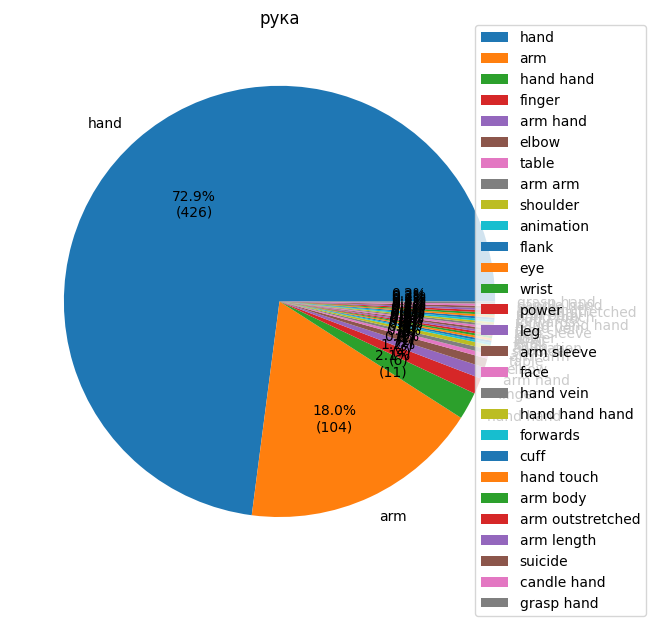

In [107]:
plot_variety_pie(data[0], word)

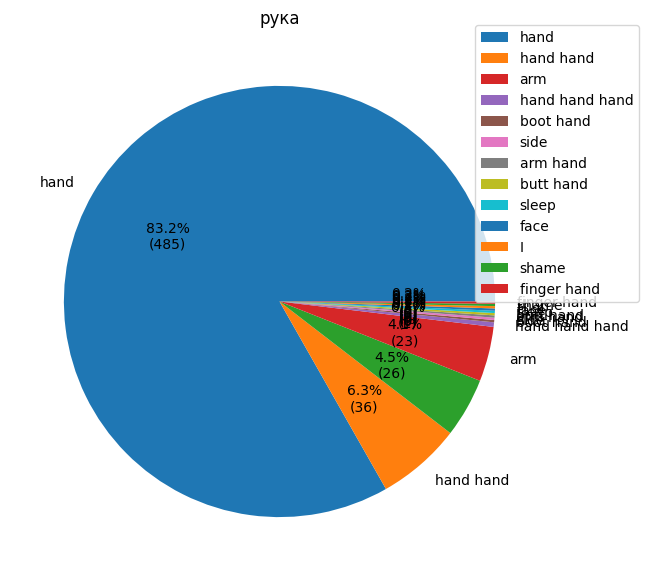

In [97]:
plot_variety_pie(data[1], word)

In [122]:
def compare_dicts(variety_dict: defaultdict, translated_dict: defaultdict):
    same_set = set()
    different_set = set()
    for key, value in variety_dict.items():
        same_set = same_set.union(translated_dict[key].intersection(value))
        different_set = different_set.union(translated_dict[key].symmetric_difference(value))
    for key, value in translated_dict.items():
        same_set = same_set.union(variety_dict[key].intersection(value))
        different_set = different_set.union(variety_dict[key].symmetric_difference(value))

    print(f"same {(len(same_set)/(len(same_set) + len(different_set)))*100}%")
    return same_set, different_set

In [123]:
same_set, different_set = compare_dicts(data[0], data[1])

same 69.86301369863014%


In [133]:
with open("./tmpfile.txt", "wt") as file:
    for i in different_set:
        file.write(f"SENTENCE NUMBER: {i}\n\n")
        file.write(f"RU: {ru_corpus_raw[i]}\n\n")
        file.write(f"EN: {en_corpus_raw[i]}\n\n")
        file.write(f"TRANSLATED: {translated_corpus_raw[i]}\n\n")
        file.write("=========================\n\n")

In [140]:
from easynmt import EasyNMT
model = EasyNMT('opus-mt')

In [139]:
model.translate(ru_corpus_raw[2050], target_lang='en', beam_size=30)

'Laska kept sticking her head under his arm.'